In [100]:
import matplotlib
matplotlib.rcParams['figure.figsize']=(10.0,10.0)
from matplotlib import pyplot as plt

import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from IPython import display


def activation(z,derivative=False):
    if derivative:
        return activation(z)*(1-activation(z))
    else:
        return 1/(1+np.exp(-z))
def cost_function(y_true,y_pred):
    n=y_pred.shape[1]
    cost=(1./(2*n))*np.sum((y_true-y_pred)**2)
    return cost
def cost_function_prime(y_true,y_pred):
    cost_prime=y_pred-y_true
    return cost_prime

In [101]:
class NeuralNetwork(object):
    def __init__(self,size,seed=42):
        self.seed=42
        np.random.seed(self.seed)
        self.size=size
        self.weights=[np.random.randn(self.size[i],self.size[i-1])*np.sqrt(1/self.size[i-1]) for i in range(1,len(self.size))]
        self.biases=[np.random.randn(n,1) for n in self.size[1:]]#print weights to seef what np.sqrt is doing
    def forward(self,input):
        a=input
        pre_activations=[]
        activations=[a]
        for w,b in zip(self.weights,self.biases):
            z=np.dot(w,a)+b
            a=activation(z)
            pre_activations.append(z)
            activations.append(a)
        return a,pre_activations,activations
    def compute_deltas(self,pre_activations,y_true,y_pred):
        delta_L=cost_function_prime(y_true,y_pred)*activation(pre_activations[-1],derivative=True)
        deltas=[0]*(len(self.size)-1)
        deltas[-1]=delta_L
        for l in range(len(deltas)-2,-1,-1):
            delta=np.dot(self.weights[l+1].transpose(),deltas[l+1])*activation(pre_activations[l],derivative=True)
            deltas[l]=delta
        return deltas
    def backpropagate(self,deltas,pre_activations,activations):
        dW=[]
        db=[]
        deltas=[0]+deltas
        for l in range(1,len(self.size)):
            dW_l=np.dot(deltas[l],activations[l-1].transpose())
            db_l=deltas[l]
            dW.append(dW_l)
            db.append(np.expand_dims(db_l.mean(axis=1),1))
        return dW,db
    def plot_decision_regions(self,X,y,iteration,train_loss,val_loss,train_acc,val_acc,res=0.01):
        X,y=X.T,y.T
        #NOTE: Here we are assuming that there are only two features ie: the plot will be 2-D
        x_min,x_max=X[:,0].min()-0.5,X[:,0].max()+0.5
        y_min,y_max=X[:,1].min()-0.5,X[:,1].max()+0.5
        xx,yy=np.meshgrid(np.arange(x_min,x_max,res),np.arange(y_min,y_max,res))
        Z=self.predict(np.c_[xx.ravel(),yy.ravel()].T)
        Z=Z.reshape(xx.shape)
        plt.contourf(xx,yy,Z,alpha=0.5)
        plt.xlim(xx.min(),xx.max())
        plt.ylim(yy.min(),yy.max())
        plt.scatter(X[:,0],X[:,1],c=y.reshape(-1),alpha=0.2)
        message = 'iteration: {} | train loss: {} | val loss: {} | train acc: {} | val acc: {}'.format(iteration,
                                                                                                     train_loss, 
                                                                                                     val_loss, 
                                                                                                     train_acc, 
                                                                                                     val_acc)
        plt.title(message)
    def train(self,X,y,batch_size,epochs,learning_rate,validation_split=0.2,print_every=10,tqdm_=True,plot_every=None):
        history_train_losses=[]
        history_train_accuracies=[]
        history_test_losses=[]
        history_test_accuracies=[]
        
        x_train,x_test,y_train,y_test=train_test_split(X.T,y.T,test_size=validation_split,)
        x_train, x_test, y_train, y_test = x_train.T, x_test.T, y_train.T, y_test.T 

        if tqdm_:
            epoch_iterator=tqdm(range(epochs))
        else:
            epoch_iterator=range(epochs)
        for e in epoch_iterator:
            if x_train.shape[1]%batch_size==0:
                n_batches=int(x_train.shape[1]/batch_size)
            else:
                n_batches=int(x_train.shape[1]/batch_size)-1
            
            x_train,y_train=shuffle(x_train.T,y_train.T)
            x_train,y_train = x_train.T,y_train.T
            
            
            batches_x=[x_train[:,batch_size*i : batch_size*(i+1)] for i in range(0,n_batches)]
            batches_y=[y_train[:,batch_size*i : batch_size*(i+1)] for i in range(0,n_batches)]
            
            train_losses=[]
            train_accuracies=[]
            
            test_losses=[]
            test_accuracies=[]
            
            dw_per_epoch=[np.zeros(w.shape) for w in self.weights]
            db_per_epoch=[np.zeros(b.shape) for b in self.biases]
            
            for batch_x,batch_y in zip(batches_x,batches_y):
                batch_y_pred,pre_activations,activations=self.forward(batch_x)
                deltas=self.compute_deltas(pre_activations,batch_y,batch_y_pred)
                dW,db = self.backpropagate(deltas,pre_activations,activations)
                for i,(dw_i,db_i) in enumerate(zip(dW,db)):
                    dw_per_epoch[i]+=dw_i/batch_size
                    db_per_epoch[i]+=db_i/batch_size
                    
                batch_y_train_pred=self.predict(batch_x)
                
                train_loss = cost_function(batch_y , batch_y_train_pred)
                train_losses.append(train_loss)
                train_accuracy = accuracy_score(batch_y.T,batch_y_train_pred.T)
                train_accuracies.append(train_accuracy)
                
                batch_y_test_pred = self.predict(x_test)

                test_loss = cost_function(y_test, batch_y_test_pred)
                test_losses.append(test_loss)
                test_accuracy = accuracy_score(y_test.T, batch_y_test_pred.T)
                test_accuracies.append(test_accuracy)
              
            # weight Updations
            for i,(dw_epoch,db_epoch) in enumerate(zip(dw_per_epoch , db_per_epoch)):
                self.weights[i]=self.weights[i]-learning_rate * dw_epoch
                self.biases[i]=self.biases[i]-learning_rate * db_epoch
            
            history_train_losses.append(np.mean(train_losses))
            history_train_accuracies.append(np.mean(train_accuracies))
            
            history_test_losses.append(np.mean(test_losses))
            history_test_accuracies.append(np.mean(test_accuracies))
            
            if not plot_every:
                if e % plot_every==0:
                    print('Epoch {} / {} | train loss: {} | train accuracy: {} | val loss : {} | val accuracy : {} '.format(
                        e, epochs, np.round(np.mean(train_losses), 3), np.round(np.mean(train_accuracies), 3), 
                        np.round(np.mean(test_losses), 3),  np.round(np.mean(test_accuracies), 3)))
            else:
                if e % plot_every==0:
                    self.plot_decision_regions(x_train,y_train,e,np.round(np.mean(train_losses),4),np.round(np.mean(test_losses),4),np.round(np.mean(train_accuracies),4),np.round(np.mean(test_accuracies),4))
                    plt.show()
                    display.display(plt.gcf())
                    display.clear_output(wait=True)
        
        self.plot_decision_regions(X,y,e,
                                   np.round(np.mean(train_losses), 4), 
                                    np.round(np.mean(test_losses), 4),
                                    np.round(np.mean(train_accuracies), 4), 
                                    np.round(np.mean(test_accuracies), 4), 
                                    )
        history = {'epochs': epochs,
                   'train_loss': history_train_losses, 
                   'train_acc': history_train_accuracies,
                   'test_loss': history_test_losses,
                   'test_acc': history_test_accuracies
                   }
        return history
                
            
                
        
    
    def predict(self,a):
        for w,b in zip(self.weights,self.biases):
            z=np.dot(w,a)+b
            a=activation(z)
        predictions=(a>0.5).astype(int)
        return predictions
        
            
    
        
        

In [102]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets

In [119]:
def plot_history(history):
    n = history['epochs']
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    n = 4000
    plt.plot(range(history['epochs'])[:n], history['train_loss'][:n], label='train_loss')
    plt.plot(range(history['epochs'])[:n], history['test_loss'][:n], label='test_loss')
    plt.title('train & test loss')
    plt.grid(1)
    plt.xlabel('epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(history['epochs'])[:n], history['train_acc'][:n], label='train_acc')
    plt.plot(range(history['epochs'])[:n], history['test_acc'][:n], label='test_acc')
    plt.title('train & test accuracy')
    plt.grid(1)
    plt.xlabel('epochs')
    plt.legend()


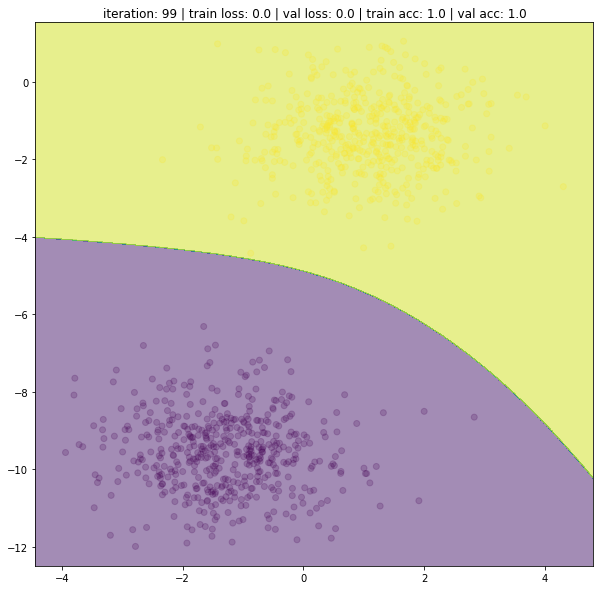

In [120]:
data = datasets.make_blobs(n_samples=1000, centers=2, random_state=2)
X = data[0].T
y = np.expand_dims(data[1], 1).T

neural_net =NeuralNetwork([2, 4, 4, 1], seed=0)
history = neural_net.train(X=X, y=y, batch_size=16, epochs=100, learning_rate=0.4, print_every=200, validation_split=0.2,
                          tqdm_=False, plot_every=10)

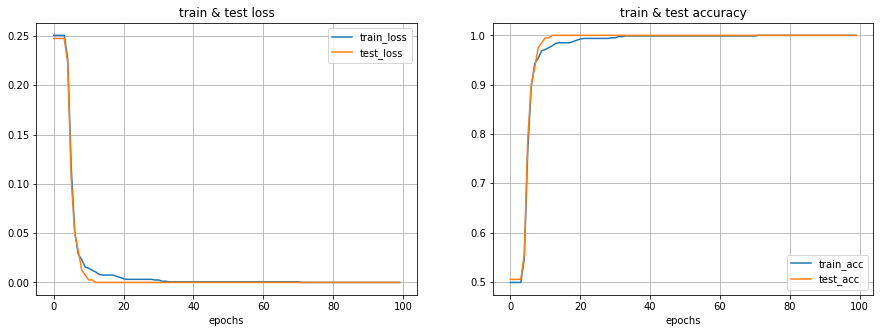

In [121]:
plot_history(history)

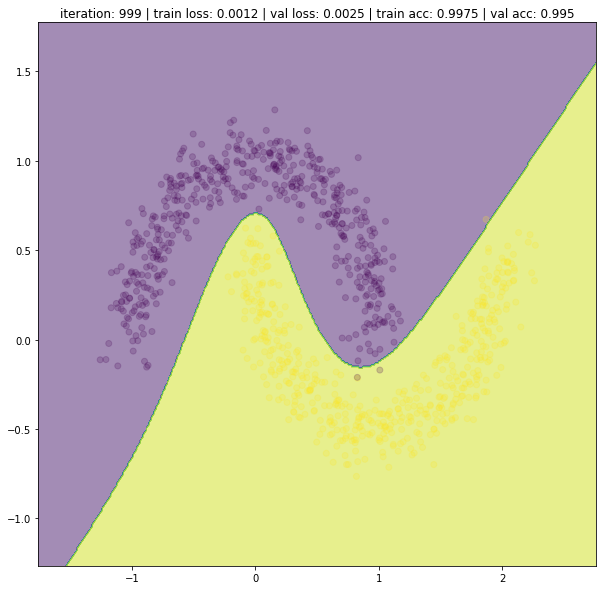

In [122]:
data = datasets.make_moons(n_samples=1000, noise=0.1)
X = data[0].T
y = np.expand_dims(data[1], 1).T

neural_net = NeuralNetwork([2, 4, 4, 1], seed=2)
history = neural_net.train(X=X, y=y, batch_size=32, epochs=1000, learning_rate=0.4, print_every=200, validation_split=0.2,
                          tqdm_=False, plot_every=15)

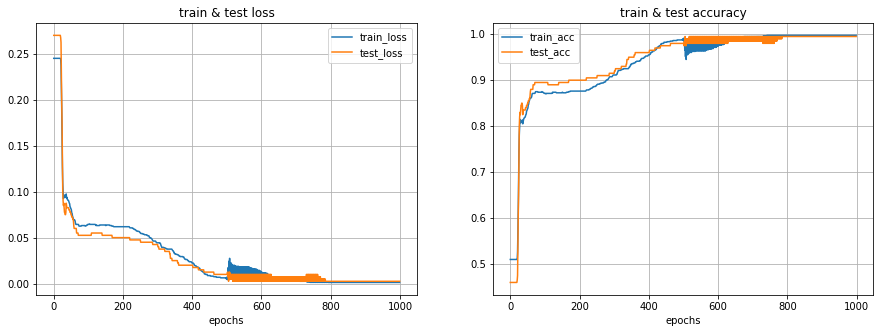

In [123]:
plot_history(history)


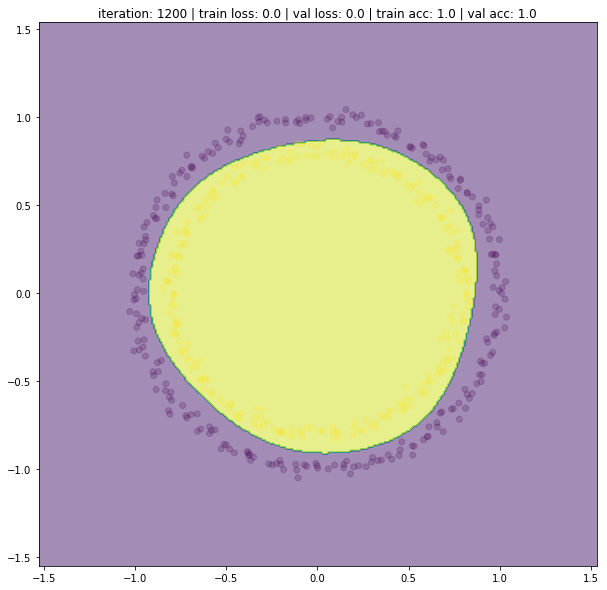

In [124]:
data = datasets.make_circles(n_samples=500, noise=0.025)
X = data[0].T
y = np.expand_dims(data[1], 1).T

neural_net = NeuralNetwork([2, 4, 1], seed=11)
history = neural_net.train(X=X, y=y, batch_size=16, epochs=1201, learning_rate=0.4, print_every=200, validation_split=0.2,
                          tqdm_=False, plot_every=50)


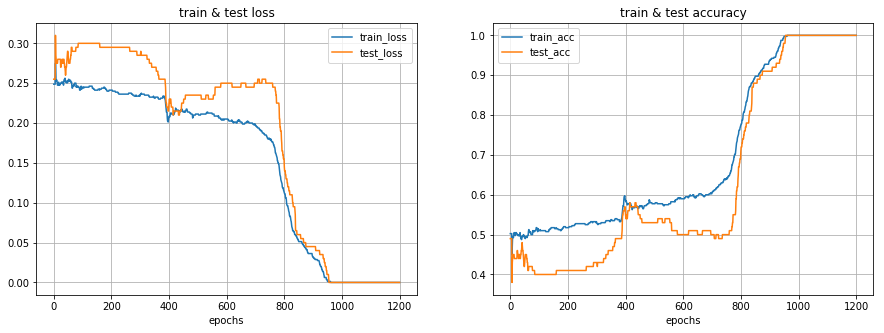

In [125]:
plot_history(history)
